In [1]:
import matplotlib.pyplot as plt
from mpi4py import MPI
from petsc4py.PETSc import ScalarType 
import numpy as np
from matplotlib.font_manager import FontProperties

import ufl
from dolfinx import fem, io, mesh, plot
from dolfinx.fem.petsc import LinearProblem
from ufl import ds, dx, grad, inner


In [2]:
msh = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0.0, 0.0), (1.0, 1.0)), n=(16, 16),
                            cell_type=mesh.CellType.triangle)
V = fem.functionspace(msh, ("Lagrange", 1))

In [3]:
facets = mesh.locate_entities_boundary(msh, dim=(msh.topology.dim - 1),
                                       marker=lambda x: np.logical_or.reduce((
                                           np.isclose(x[0], 0.0),
                                           np.isclose(x[0], 1.0),
                                           np.isclose(x[1], 0.0),
                                           np.isclose(x[1], 1.0))))

In [4]:
dofs = fem.locate_dofs_topological(V=V, entity_dim=1, entities=facets)


In [5]:
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

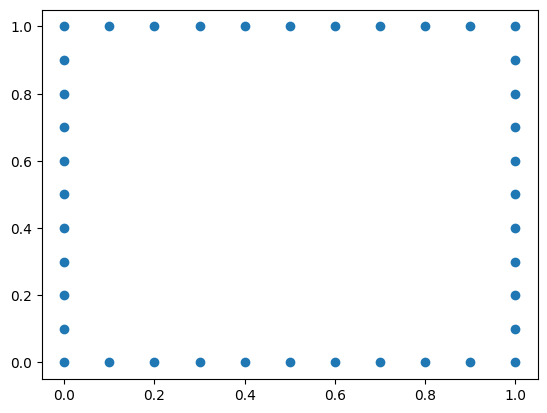

In [6]:
# create boundary points, starting from (0,0), clockwise
n = 11;
x = np.linspace(0, 1, n)
c = np.zeros((4*n-4,2))
c[n:2*n-1,0] = x[1:]
c[2*n-1:3*n-3,0] = 1
c[3*n-3:,0] = np.flip(x[1:],axis = 0)
c[0:n,1] = x
c[n:2*n-2,1] = 1
c[2*n-2:3*n-3,1] = np.flip(x[1:],axis = 0)
c
plt.scatter(c[:,0], c[:,1]) 

In [7]:
###  The source/receiver functions near the boundaries
f_all = []
for i in range(40):
    f = fem.Function(V)
    f.interpolate(lambda x: np.exp(-(pow(x[0] - c[i,0] ,2)+pow(x[1] - c[i,1],2))*20) )
    f_all.append(f)


In [8]:
u_trial = ufl.TrialFunction(V)
u_test = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(msh)

atrue = ufl.sin(x[0]*3)**2 + ufl.sin(x[1]*3)**2 + ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2  

A = inner(atrue * grad(u_trial), grad(u_test)) * dx

D = np.zeros((40,40))
for j in range(40):
    L_true = f_all[j] * u_test * dx
    # solve the forward/state problem to generate synthetic observations
    problem = LinearProblem(A, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
    u_j = problem.solve()
    
    for i in range(40):
        # d_{ij} = \mathcal{P}_i(u_j)

        D[i,j] = fem.assemble_scalar(fem.form(inner( u_j , f_all[i]) * dx ))


In [13]:
nk = 51
obj_all_inf = np.zeros(nk,)
obj_all_zero = np.zeros(nk,)
obj_all_small = np.zeros(nk,)
obj_all_large = np.zeros(nk,)
c_all = np.linspace(0, 2, nk)

w_all = []
for k in range(nk):
    # a = interpolate(Expression('8. - 2.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2)) + c', c = k*0.1, degree=5), Va)
    # a = interpolate(Expression('pow(sin(x[0]*3),2) + pow(sin(x[1]*3),2) + (1+c)*(pow(sin(10*x[0]),2) + pow(sin(10*x[1]),2))', 
    #                            c = k*10, degree=2), Va)

    c = c_all[k]
    a = ufl.sin(x[0]*3)**2 + ufl.sin(x[1]*3)**2 + (1+100*c)*ufl.sin(10*x[0])**2 + ufl.sin(10*x[1])**2
     
    A = inner(a * grad(u_trial), grad(u_test)) * dx
    
    w_all = [] # initialize {w_i}
    E = np.zeros((40,40))
    G = np.zeros((40,40))
    for j in range(40):
        L_true = f_all[j] * u_test * dx
        # solve the forward/state problem to generate synthetic observations
        problem = LinearProblem(A, L_true, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
        u_j = problem.solve()
        
        w_all.append(u_j)
        for i in range(40):
            E[i,j] = D[i,j] -  fem.assemble_scalar(fem.form(inner( u_j , f_all[i]) * dx ))
            
    for j in range(40):
        for i in range(j+1):
            G[i,j] =fem.assemble_scalar(fem.form( inner( grad(w_all[i]) , grad(w_all[j])) * dx ))
            G[j,i] = G[i,j] # since G is symmetric in this case
    # np.linalg.cond(G)
    ### J = 0.5*{trace}[E(c)^*(I+1/rho*G(c))^{-1}E(c)]
    # G = G*1e9
    obj_all_inf[k] =  0.5*np.trace(E.transpose()*E)
    obj_all_large[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e-9)*E)
    obj_all_small[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(np.eye(40) + G/1e-15)*E)
    obj_all_zero[k] =  0.5*np.trace(E.transpose()* np.linalg.inv(G)*E)

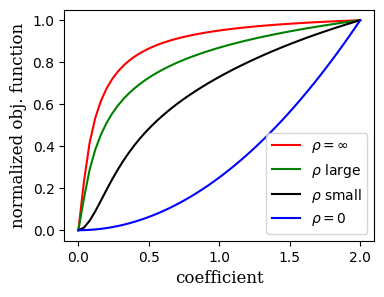

In [15]:
font = FontProperties()
font.set_family('serif')
# font.set_name('Times New Roman')
font.set_size('12')
# font.set_style('italic')

fig, ax =  plt.subplots(figsize=(4, 3))

coeffs = c_all

ax.plot(coeffs, obj_all_inf/np.max(obj_all_inf),color='r',label =  r'$\rho = \infty$')
ax.plot(coeffs, obj_all_large/np.max(obj_all_large),color='g',label = r'$\rho$ large')
ax.plot(coeffs, obj_all_small/np.max(obj_all_small),color='k',label = r'$\rho$ small')
ax.plot(coeffs, obj_all_zero/np.max(obj_all_zero),color='b',label = r'$\rho= 0$')
ax.legend()
ax.set_xlabel('coefficient', fontproperties=font)
ax.set_ylabel('normalized obj. function', fontproperties=font)
plt.savefig('Poisson2D-full-basis-H1semi-inner.pdf',bbox_inches='tight')  